In [41]:
# # Packages 

import os 
import random

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch.nn as nn
from torchvision.utils import save_image
import torch.nn.functional as F


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

#data, labels and classes 
classes= ['0','1']
data= 'data/spectrograms/'
labels='data/labels_extension.txt'

data_content= os.listdir(data) #list of names of files for images
all_indexes= np.array(range(len(data_content))) #indexes of images

In [90]:
class SpectrogramDataset(Dataset):
    def __init__(self, path_dataset, path_labels):
        self.labels = open(path_labels, 'r').read().split('\n')
        self.path_dataset = path_dataset
        self.images = os.listdir(path_dataset)
    
    def __getitem__(self, index):
        image_return = np.array(Image.open(os.path.join(self.path_dataset, self.images[index])))
        label = self.labels[index]
        return torch.tensor(image_return), torch.tensor(int(label))
    
    def __len__(self):
        return len(self.labels)


tensor(1)
541


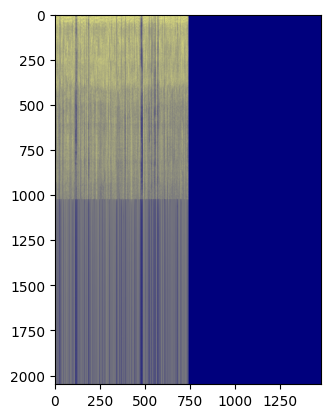

In [91]:
dataset_s = SpectrogramDataset(data, labels)

spec, label = dataset_s[52]

plt.imshow(spec)
print(label)
print(len(dataset_s))


In [46]:
#Train/Validation/Test

all_indexes= np.array(range(len(dataset_s)))

random.seed(42)
random.shuffle(all_indexes)
n1 = int(0.8*len(all_indexes))
n2 = int(0.9*len(all_indexes))

indices_train = all_indexes[:n1]
indices_val = all_indexes[n1:n2]
indices_test = all_indexes[n2:]

In [47]:
#Define the model (RestNet18)

def get_model():
    model = models.resnet18(pretrained=True)
    device= 'cpu'
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [48]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
#summary(model, torch.zeros(1,3,224,224))

d:\CCiL\TFM\model\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\CCiL\TFM\model\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [109]:
#Training 

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x).type(dtype=torch.float)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [85]:
loss_fn

BCELoss()

In [110]:
X, y = dataset_s[indices_train[4]]
X = X.permute(2,0,1).float().unsqueeze(0)
y= y.unsqueeze(0).unsqueeze(0).type(dtype=torch.float)
print(y.type())
train_batch(X, y, model, optimizer, loss_fn)

torch.FloatTensor


0.7191469669342041

<class 'torch.Tensor'>


In [54]:
X


tensor([[[  0,   0, 139],
         [  0,   0, 139],
         [  0,   0, 139],
         ...,
         [  0,   0, 139],
         [  0,   0, 139],
         [  0,   0, 139]],

        [[162, 162, 139],
         [134, 134, 139],
         [146, 146, 139],
         ...,
         [  0,   0, 139],
         [  0,   0, 139],
         [  0,   0, 139]],

        [[166, 166, 139],
         [131, 131, 139],
         [145, 145, 139],
         ...,
         [  0,   0, 139],
         [  0,   0, 139],
         [  0,   0, 139]],

        ...,

        [[ 64,  65, 139],
         [ 81,  81, 139],
         [ 91,  91, 139],
         ...,
         [  0,   0, 139],
         [  0,   0, 139],
         [  0,   0, 139]],

        [[ 68,  68, 139],
         [ 81,  84, 139],
         [ 91,  91, 139],
         ...,
         [  0,   0, 139],
         [  0,   0, 139],
         [  0,   0, 139]],

        [[ 60,  61, 139],
         [ 77,  75, 139],
         [ 86,  85, 139],
         ...,
         [  0,   0, 139],
        